In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines
from src.mar import MAR_Estimator
from src.var import VAR_Estimator

def get_kronecker_score(Phi, m):
    """
    Calculates the energy ratio of the first singular value of the rearranged Phi.
    Phi shape is (m*m, m*m).
    """
    # Reshape to (m, m, m, m) and permute to (m, m, m, m) -> (i, k, j, l)
    Phi_reshaped = Phi.reshape(m, m, m, m)
    Phi_permuted = Phi_reshaped.transpose(0, 2, 1, 3)
    R_Phi = Phi_permuted.reshape(m*m, m*m)
    
    s = np.linalg.svd(R_Phi, compute_uv=False)
    # Score: Energy of 1st component / Total Energy
    return (s[0]**2) / np.sum(s**2)

def generate_mixed_phi(m, alpha, seed=None):
    """
    Generates a Phi matrix (size m^2 x m^2) mixing MAR and VAR structure.
    """
    rng = np.random.default_rng(seed)
    
    # MAR Component: A (x) B
    A = rng.normal(0, 1, (m, m))
    B = rng.normal(0, 1, (m, m))
    Phi_MAR = np.kron(A, B)
    
    # VAR Component: Random Full Rank
    Phi_VAR = rng.normal(0, 1, (m*m, m*m))
    
    # Mix
    Phi_mix = alpha * Phi_MAR + (1 - alpha) * Phi_VAR
    
    # Normalize Spectral Radius to < 1 for stability
    rho = np.max(np.abs(np.linalg.eigvals(Phi_mix)))
    # Scale to 0.95 to ensure it's a stable but persistent process
    if rho > 0:
        Phi_mix = Phi_mix / (rho + 1e-6) * 0.95 
    
    return Phi_mix

def run_energy_experiment_multisize(estimators, m_list, n_simulations=30, T=300):
    """
    Runs the energy vs RMSE experiment for multiple matrix sizes.
    
    Returns:
        dict: Nested dict results[m_size] = { 'energy': [], 'rmse': {method: []} }
    """
    full_results = {}
    
    print(f"Starting Experiment over sizes: {m_list}")
    
    for m in m_list:
        print(f"  > Simulating for Grid Size: {m}x{m} (Total Feats: {m*m})...")
        
        # Initialize storage for this m
        current_results = {
            "energy": [],
            "rmse": {name: [] for name in estimators.keys()}
        }
        
        # Sweep alpha
        alphas = np.linspace(0, 1, n_simulations)
        
        for i, alpha in enumerate(alphas):
            # 1. Generate Matrix
            Phi = generate_mixed_phi(m, alpha, seed=i*100 + m)
            
            # 2. Measure Exact Energy (X-axis)
            score = get_kronecker_score(Phi, m)
            current_results["energy"].append(score)
            
            # 3. Generate Data (Vector AR(1) process)
            n_features = m * m
            epsilon = np.random.normal(0, 1, (T, n_features))
            Y = np.zeros((T, n_features))
            Y[0] = epsilon[0]
            
            # Simple AR process generation
            for t in range(1, T):
                Y[t] = Y[t-1] @ Phi.T + epsilon[t]
                        
            # 4. Fit & Evaluate
            for name, est in estimators.items():
                try:
                    est.fit(Y)
                    preds = est.predict(Y)
                    
                    # Compute RMSE
                    rmse = np.sqrt(mean_squared_error(Y, preds))
                    current_results["rmse"][name].append(rmse)
                except Exception as e:
                    print(f"    Error in {name} at m={m}: {e}")
                    current_results["rmse"][name].append(np.nan)

        full_results[m] = current_results
        
    return full_results


# --- EXECUTION SNIPPET ---
# Define grid dimensions for MAR (e.g., 2x2 = 4 features total)
sizes_to_test = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize Estimators (Ensure they match the data dim m_total)
# You might need to adjust your 'm' parameter in your actual classes
estimators = {
    "VAR (OLS)": VAR_Estimator(mode='ols'),
    "MAR (LSE)": MAR_Estimator(mode='lse')
}

# 2. Run Experiment
# Ensure your estimators are instantiated. 
# They will be re-fitted inside the loop, so reusing the object is fine.
results = run_energy_experiment_multisize(estimators, sizes_to_test, n_simulations=50, T=500)

Starting Experiment over sizes: [2, 3, 4, 5, 6, 7, 8, 9, 10]
  > Simulating for Grid Size: 2x2 (Total Feats: 4)...
  > Simulating for Grid Size: 3x3 (Total Feats: 9)...
  > Simulating for Grid Size: 4x4 (Total Feats: 16)...
  > Simulating for Grid Size: 5x5 (Total Feats: 25)...
  > Simulating for Grid Size: 6x6 (Total Feats: 36)...
  > Simulating for Grid Size: 7x7 (Total Feats: 49)...
  > Simulating for Grid Size: 8x8 (Total Feats: 64)...
  > Simulating for Grid Size: 9x9 (Total Feats: 81)...
  > Simulating for Grid Size: 10x10 (Total Feats: 100)...


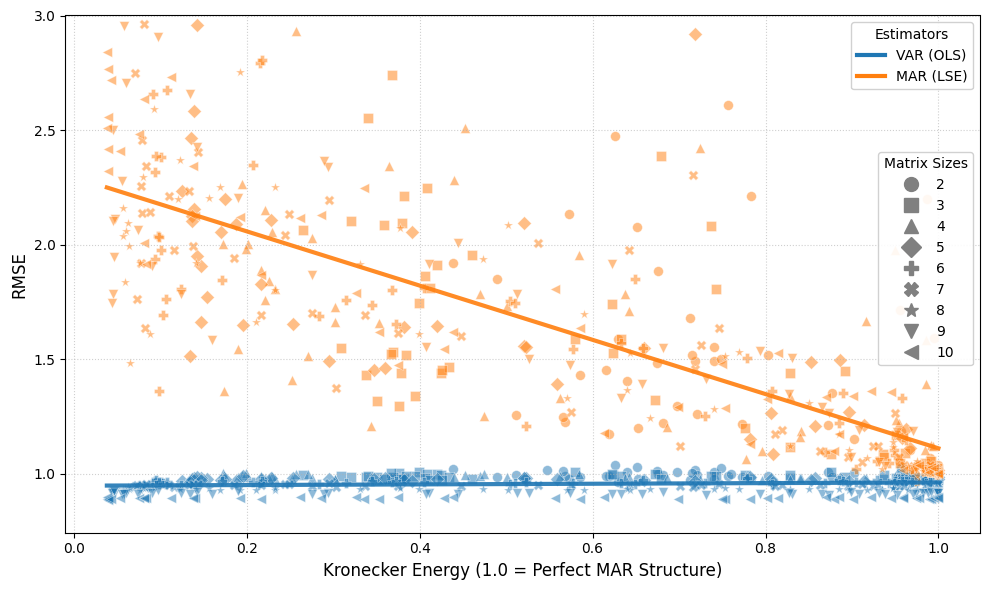

In [ ]:
def plot_energy(results_dict):
    """
    Plots all results in a single chart with:
    - Scatter points distinguished by size (shape) and estimator (color).
    - A SINGLE trend line per estimator (aggregated across all sizes).
    """
    m_sizes = sorted(list(results_dict.keys()))
    
    # Get method names from the first entry
    first_m = m_sizes[0]
    method_names = list(results_dict[first_m]["rmse"].keys())
    
    # --- DATA AGGREGATION STORAGE ---
    # We need to collect all points for each method to fit one global line
    agg_data = {name: {'energy': [], 'rmse': []} for name in method_names}
    
    # --- STYLE CONFIGURATION ---
    markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>']  # Extend as needed
    if len(m_sizes) > len(markers):
        markers = markers * (len(m_sizes) // len(markers) + 1)

    cmap = plt.get_cmap("tab10")
    colors = {name: cmap(i) for i, name in enumerate(method_names)}
    
    plt.figure(figsize=(10, 6))
    
    # --- 1. SCATTER PLOT LOOP ---
    for i, m in enumerate(m_sizes):
        data = results_dict[m]
        energies = np.array(data["energy"])
        current_marker = markers[i]
        
        for method in method_names:
            rmses = np.array(data["rmse"][method])
            current_color = colors[method]
            
            # Filter NaNs
            valid_mask = ~np.isnan(rmses)
            e_clean = energies[valid_mask]
            r_clean = rmses[valid_mask]
            
            # Store for later fitting
            agg_data[method]['energy'].extend(e_clean)
            agg_data[method]['rmse'].extend(r_clean)
            
            # Scatter Plot
            plt.scatter(
                e_clean, r_clean, 
                color=current_color, 
                marker=current_marker, 
                alpha=0.5, 
                s=50, 
                edgecolor='white', 
                linewidth=0.5
            )

    # --- 2. TREND LINE LOOP (One per Estimator) ---
    for method in method_names:
        # Retrieve all data points for this method
        all_e = np.array(agg_data[method]['energy'])
        all_r = np.array(agg_data[method]['rmse'])
        
        if len(all_e) > 2:
            # Sort by energy for proper line plotting
            sorted_idx = np.argsort(all_e)
            e_sorted = all_e[sorted_idx]
            r_sorted = all_r[sorted_idx]
            
            # Fit Polynomial (Degree 2 for curvature)
            # You can increase degree to 3 if the relationship is complex
            z = np.polyfit(e_sorted, r_sorted, 1)
            p = np.poly1d(z)
            
            # Plot the single trend line
            plt.plot(
                e_sorted, p(e_sorted), 
                color=colors[method], 
                linestyle='-', 
                linewidth=3, 
                alpha=0.9,
                label=f"{method} (Trend)" 
            )

    # --- LEGENDS ---
    # 1. Color Legend (Methods)
    # We use the line handle since the line is the main focus now
    method_handles = [
        mlines.Line2D([], [], color=colors[name], linewidth=3, label=name) 
        for name in method_names
    ]
    legend1 = plt.legend(handles=method_handles, title="Estimators", 
                         loc='upper right', bbox_to_anchor=(1, 1), framealpha=0.9)
    plt.gca().add_artist(legend1)

    # 2. Marker Legend (Sizes)
    size_handles = [
        mlines.Line2D([], [], color='gray', marker=markers[i], linestyle='', 
                      label=f"{m}", markersize=10) 
        for i, m in enumerate(m_sizes)
    ]
    plt.legend(handles=size_handles, title="Matrix Sizes", 
               loc='upper right', bbox_to_anchor=(1, 0.75), framealpha=0.9)

    # --- FORMATTING ---
    plt.xlabel("Kronecker Energy (1.0 = Perfect MAR Structure)", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.ylim(top=3)
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    return plt.gcf(), plt.gca()

# 3. Plot
fig, ax = plot_energy(results)
fig.savefig('energy.svg')